In [1]:
# Import required libraries
import itertools
import os
from os import path as pt
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split

from hyperparameters import SIGCWGAN_CONFIGS
# from lib import ALGOS
from lib.algos.base import BaseConfig
# from lib.data import download_man_ahl_dataset, download_mit_ecg_dataset
from lib.data import get_data
from lib.plot import savefig, create_summary
from lib.utils import pickle_it
from train import get_algo, get_algo_config, get_dataset_configuration, set_seed

In [2]:
dataset_size = 10000
seed = 42
mc_samples = 1000 # number of samples for MC calculation in SigCWGAN
length = 249 # SigCWGAN length
p = 20 # number of past time steps
q = 20 # number of future time steps
epochs = 1000 # number of epochs
batch_size = 200 # batch size
long_length = 7216
long_dataset_size = 10000

In [3]:
# Configuration setup (replacing argparse)
class Args:
    def __init__(self):
        self.base_dir = './numerical_results'
        self.use_cuda = True  # Modify based on your needs
        self.device = 0
        self.num_seeds = 1
        self.initial_seed = 0
        # self.datasets = ['STOCKS']
        # self.algos = ['SigCWGAN']
        self.batch_size = batch_size
        self.p = p  # number of past time steps
        self.q = q  # number of future time steps
        self.hidden_dims = 3 * (50,)
        self.total_steps = epochs # number of epochs

# Create args instance
args = Args()

In [4]:
dataset = 'STOCKS'
algo_id = 'SigCWGAN'
base_config = BaseConfig(
    device='cuda:{}'.format(args.device) if args.use_cuda and torch.cuda.is_available() else 'cpu',
    seed=seed,
    batch_size=args.batch_size,
    hidden_dims=args.hidden_dims,
    p=args.p,
    q=args.q,
    total_steps=args.total_steps,
    mc_samples=mc_samples,
)
set_seed(seed)
generator = get_dataset_configuration(dataset)
spec, data_params = next(generator)
base_dir=args.base_dir

print('Start of training. CUDA: %s' % args.use_cuda)
""" Create the experiment directory, calibrate algorithm, store relevant parameters. """
print('Executing: %s, %s, %s' % (algo_id, dataset, spec))
experiment_directory = pt.join(base_dir, dataset, spec, 'seed={}'.format(base_config.seed), algo_id)
if not pt.exists(experiment_directory):
    # if the experiment directory does not exist we create the directory
    os.makedirs(experiment_directory)
# Set seed for exact reproducibility of the experiments
set_seed(base_config.seed)
# initialise dataset and algo
pipeline, x_real_raw, x_real = get_data(dataset, base_config.p, base_config.q, **data_params)

x_real = x_real.to(base_config.device)
ind_train = int(x_real.shape[0] * 0.8)
# ind_train = int(x_real.shape[0] * 0.8278) # adjusted so that last date of training data is 2018-09-19

x_real_train, x_real_test = x_real[:ind_train], x_real[ind_train:] #train_test_split(x_real, train_size = 0.8)

algo = get_algo(algo_id, base_config, dataset, data_params, x_real_train)
# Train the algorithm
algo.fit()
# create summary
create_summary(dataset, base_config.device, algo.G, base_config.p, base_config.q, x_real_test)
savefig('summary.png', experiment_directory)
x_fake = create_summary(dataset, base_config.device, algo.G, base_config.p, 8000, x_real_test, one=True)
savefig('summary_long.png', experiment_directory)
plt.plot(x_fake.cpu().numpy()[0, :2000])
savefig('long_path.png', experiment_directory)
# Pickle generator weights, real path and hyperparameters.
# pickle_it(x_real, pt.join(pt.dirname(experiment_directory), 'x_real.torch'))
# pickle_it(x_real_test, pt.join(pt.dirname(experiment_directory), 'x_real_test.torch'))
# pickle_it(x_real_train, pt.join(pt.dirname(experiment_directory), 'x_real_train.torch'))
# pickle_it(algo.training_loss, pt.join(experiment_directory, 'training_loss.pkl'))
# pickle_it(algo.G.to('cpu').state_dict(), pt.join(experiment_directory, 'G_weights.torch'))
# Log some results at the end of training
algo.plot_losses()
savefig('losses.png', experiment_directory)

Start of training. CUDA: True
Executing: SigCWGAN, STOCKS, SPX


100%|███████████████████████████████████████| 1000/1000 [05:55<00:00,  2.81it/s]


In [5]:
x_real_transformed = pipeline.transform(x_real_raw)[0,:,0]
x_real_transformed.shape

torch.Size([7215])

In [6]:
x_real_transformed[:20]

tensor([ 2.6242e-01, -9.2965e-02,  3.4978e-02,  7.2376e-04,  1.2664e-01,
        -2.9885e-02, -2.9885e-02,  7.4846e-01,  5.7880e-01,  9.2077e-02,
        -8.6339e-02, -5.1535e-01, -4.1285e-01,  1.5920e-01, -1.9170e-02,
         2.5469e-01,  1.2979e-01,  3.3971e-01, -3.5863e-01,  3.1134e-01])

In [7]:
x_real[:2,:,0]

tensor([[ 2.6242e-01, -9.2965e-02,  3.4978e-02,  7.2376e-04,  1.2664e-01,
         -2.9885e-02, -2.9885e-02,  7.4846e-01,  5.7880e-01,  9.2077e-02,
         -8.6339e-02, -5.1535e-01, -4.1285e-01,  1.5920e-01, -1.9170e-02,
          2.5469e-01,  1.2979e-01,  3.3971e-01, -3.5863e-01,  3.1134e-01,
         -2.9823e-02,  3.9428e-01,  9.9596e-01,  4.0430e-01, -8.3232e-02,
          3.9270e-02, -1.9893e-01,  1.9290e-01,  6.4516e-03,  1.2863e-01,
          3.1524e-01,  9.0088e-02, -5.8401e-01,  1.0274e-01,  3.7673e-01,
          2.8790e-01,  1.7798e-01, -7.6060e-01,  5.8552e-01, -3.2309e-01],
        [-9.2965e-02,  3.4978e-02,  7.2376e-04,  1.2664e-01, -2.9885e-02,
         -2.9885e-02,  7.4846e-01,  5.7880e-01,  9.2077e-02, -8.6339e-02,
         -5.1535e-01, -4.1285e-01,  1.5920e-01, -1.9170e-02,  2.5469e-01,
          1.2979e-01,  3.3971e-01, -3.5863e-01,  3.1134e-01, -2.9823e-02,
          3.9428e-01,  9.9596e-01,  4.0430e-01, -8.3232e-02,  3.9270e-02,
         -1.9893e-01,  1.9290e-01,  6

In [8]:
x_real.shape

torch.Size([7175, 40, 1])

In [9]:
generator = algo.G
rng = np.random.default_rng(seed)
rng_idx = rng.integers(0, x_real_transformed.shape[0]-(args.p+args.q), size=dataset_size)
x_fake = []
for i in range(len(rng_idx) // batch_size):
    idx = rng_idx[i*batch_size:(i+1)*batch_size]
    x_past = x_real[idx,:args.p,:].to(base_config.device)
    # print(f'i: {i}, x_past.shape: {x_past.shape}')
    with torch.no_grad():
        x_future = generator.sample(length, x_past).detach()
    x_fake.append(x_future)
x_fake = torch.cat(x_fake, dim=0)
x_fake.shape

torch.Size([10000, 249, 1])

In [10]:
paths = x_fake[:,:,0].clone()
paths = pipeline.inverse_transform(paths)
paths = paths.cumsum(axis=1)
paths = paths.exp()
paths = torch.cat([torch.ones_like(paths[:,:1]), paths], dim=1).cpu()
log_returns = torch.diff(torch.log(paths), dim=1)
torch.save(paths, f'./data/paths_p{p}_q{q}.pt')
paths.shape, log_returns.shape

(torch.Size([10000, 250]), torch.Size([10000, 249]))

In [11]:
torch.save(paths, f'./data/paths_p{p}_q{q}.torch')

In [12]:
pipeline.inverse_transform(x_fake[:,:,0].clone())[:,:5]

tensor([[ 0.0064,  0.0020, -0.0058,  0.0051, -0.0089],
        [-0.0023, -0.0024,  0.0037,  0.0053,  0.0013],
        [ 0.0050,  0.0038,  0.0072,  0.0026,  0.0037],
        ...,
        [ 0.0024, -0.0020,  0.0036, -0.0195,  0.0118],
        [-0.0021,  0.0040,  0.0047,  0.0001, -0.0121],
        [ 0.0064, -0.0023,  0.0056,  0.0010, -0.0089]], device='cuda:0')

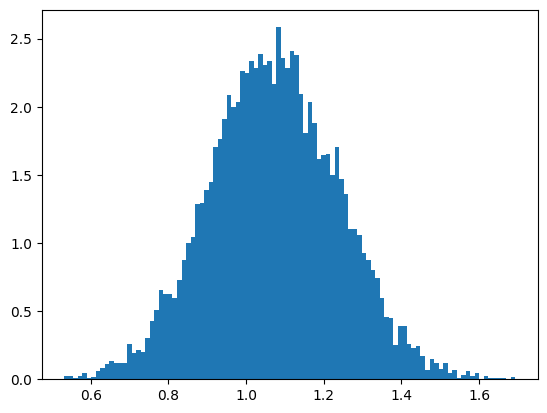

In [13]:
plt.hist(paths[:,-1], bins=100, density=True);

In [14]:
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view
hist_len = 50
rng_idx = rng.integers(0, 114, size=dataset_size)
df_spx = pd.read_csv('./data/spx_vix_df.csv', index_col=0, parse_dates=True)
df_spx = df_spx.loc['1995-02-01':'2018-09-19']
batches = sliding_window_view(df_spx['SPX'], 300)[::50]
dt_batches = sliding_window_view(df_spx.index, 300)[::50]
spx_log_returns = []
spx_ann_log_returns = []
for idx in rng_idx:
    returns = np.diff(np.log(batches[idx, hist_len:]), axis=0)
    dt = pd.Series(dt_batches[idx, hist_len:]).diff().dropna().dt.days / 365
    spx_log_returns.append(returns)
    spx_ann_log_returns.append(returns/dt)
spx_log_returns = np.array(spx_log_returns)
spx_ann_log_returns = np.array(spx_ann_log_returns)
spx_log_returns.shape, spx_ann_log_returns.shape

((10000, 249), (10000, 249))

In [15]:
spx_full_log_returns = np.diff(np.log(df_spx['SPX']), axis=0)
spx_full_ann_log_returns = spx_full_log_returns / (df_spx.index.to_series().diff().dropna().dt.days / 365).values
spx_full_log_returns.shape, spx_full_ann_log_returns.shape

((5950,), (5950,))

Quantile value: 0.023783902379113542


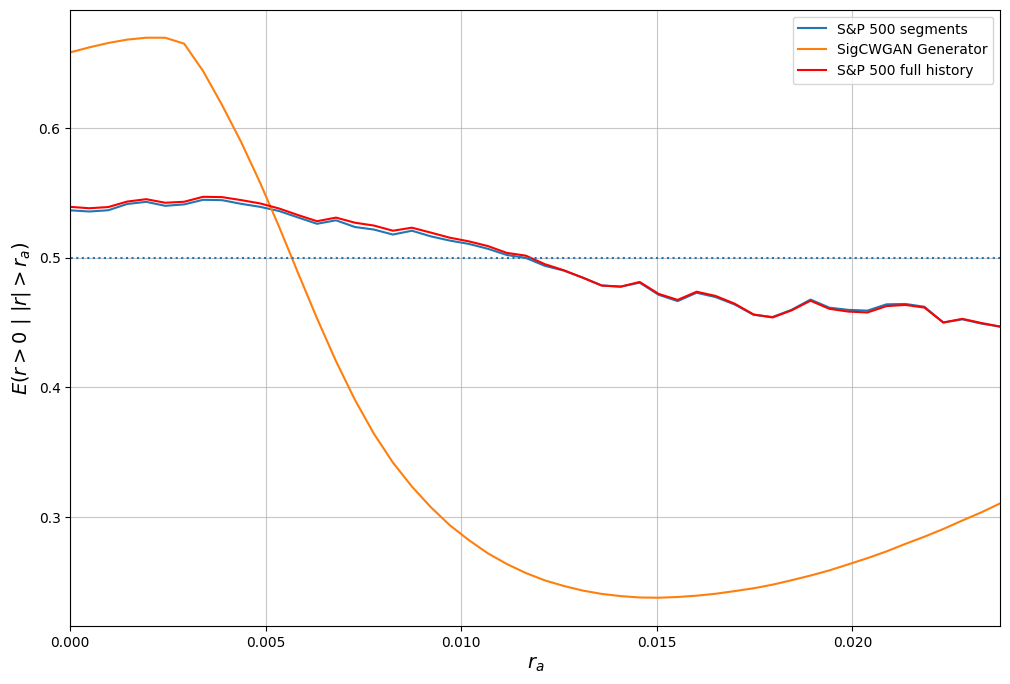

In [16]:
real_dist = spx_log_returns.ravel()
fake_dist = log_returns.numpy().ravel()
# fake_dist2 = cotgan_log_returns.ravel()
# real_dist = spx_ann_log_returns.ravel()
# fake_dist = ann_log_returns.ravel()

loss_assymetry = lambda dist, x: np.mean((dist[np.abs(dist) > x] >= 0))
x_range = np.linspace(0, np.quantile(np.abs(real_dist), .95), 50)

# fake_dist = [[loss_assymetry(r, x) for x in x_range] for r in log_returns]
# fake_dist = np.array(fake_dist)
# print(fake_dist.shape, fake_dist.mean(axis=0).shape)

print(f'Quantile value: {np.quantile(np.abs(real_dist), .95)}')

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(x_range, [loss_assymetry(real_dist, x) for x in x_range], label='S&P 500 segments')
ax.plot(x_range, [loss_assymetry(fake_dist, x) for x in x_range], label='SigCWGAN Generator')
# ax.plot(x_range, [loss_assymetry(fake_dist2, x) for x in x_range], label='COT-GAN Generator')
ax.plot(x_range, [loss_assymetry(spx_full_log_returns, x) for x in x_range], label='S&P 500 full history', color='red')
# ax.plot(x_range, [loss_assymetry(spx_full_ann_log_returns, x) for x in x_range], label='S&P 500 full history', color='red')
ax.hlines(0.5, -1, 1, linestyles='dotted');
ax.set_xlim(0, np.quantile(np.abs(real_dist), 0.95))


ax.set_xlabel('$r_a$', size=14)
ax.set_ylabel('$E(r > 0$ | $|r| > r_a)$', size=14)

ax.grid(alpha=0.7)

ax.legend();

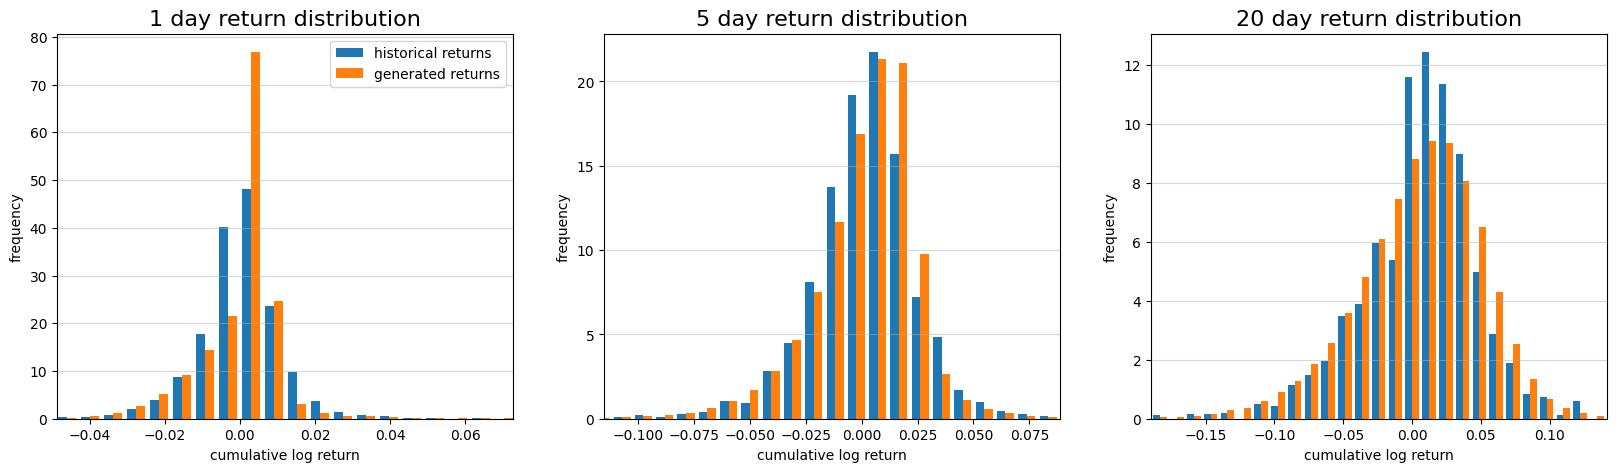

In [17]:
n_bins = 50
windows = [1, 5, 20]

fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

for i in range(len(windows)):
    if windows[i] == 1:
        real_dist = spx_log_returns
        fake_dist = log_returns
        # real_dist = spx_ann_log_returns
        # fake_dist = ann_log_returns
    else:
        real_dist = sliding_window_view(spx_log_returns, windows[i], axis=1)
        # real_dist = sliding_window_view(spx_ann_log_returns, windows[i], axis=1)
        # print(real_dist.shape)
        real_dist = real_dist[:,::windows[i],:]
        # print(real_dist.shape)
        real_dist = real_dist.sum(axis=-1)
        # print(real_dist.shape)
        fake_dist = sliding_window_view(log_returns, windows[i], axis=1)
        # fake_dist = sliding_window_view(ann_log_returns, windows[i], axis=1)
        fake_dist = fake_dist[:,::windows[i],:]
        fake_dist = fake_dist.sum(axis=-1)

    ax[i].hist([real_dist.ravel(), fake_dist.ravel()], bins=n_bins, density=True);
    ax[i].set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    ax[i].set_title('{} day return distribution'.format(windows[i]), size=16)
    ax[i].yaxis.grid(True, alpha=0.5)
    ax[i].set_xlabel('cumulative log return')
    ax[i].set_ylabel('frequency')

ax[0].legend(['historical returns', 'generated returns'])


In [18]:
from scipy.stats import skew, kurtosis
from scipy.stats import normaltest, skewtest, kurtosistest

def print_statistics(log_returns, factor=1.,
                     ref_mean=None, ref_std=None, ref_skew=None, ref_kurtosis=None,
                     log_returns2=None, n_bins=100,
                     label1='S&P 500 segments', label2='Generated', label3='S&P 500 full history'):
    if log_returns.ndim == 1:
        log_returns = log_returns.reshape(1, -1)
        plot=False
    else:
        plot=True
    means = log_returns.mean(axis=1)*factor
    stds = log_returns.std(axis=1)*factor**0.5
    skews = skew(log_returns, axis=1)
    kurtosises = kurtosis(log_returns, axis=1)

    n_cols = 1 if log_returns2 is None else 2
    if n_cols == 2:
        means2 = log_returns2.mean(axis=1)*factor
        stds2 = log_returns2.std(axis=1)*factor**0.5
        skews2 = skew(log_returns2, axis=1)
        kurtosises2 = kurtosis(log_returns2, axis=1)

    print(f'Mean annualised log return: {np.mean(means)}')
    if log_returns2 is not None: print(f'Mean of second dataset: {np.mean(means2)}')
    print(f'Std annualised log return: {np.mean(stds)}')
    if log_returns2 is not None: print(f'Std of second dataset: {np.mean(stds2)}')
    print(f'Min log return: {log_returns.min()} / Max log return: {log_returns.max()}')
    if log_returns2 is not None: print(f'Min of second dataset: {log_returns2.min()} / Max of second dataset: {log_returns2.max()}')
    print(f'Skewness: {np.mean(skews)} (0=normal)')
    if log_returns2 is not None: print(f'Skewness of second dataset: {np.mean(skews2)}')
    print(f'Kurtosis: {np.mean(kurtosises)} (0=normal under Fisher\'s definition)')
    if log_returns2 is not None: print(f'Kurtosis of second dataset: {np.mean(kurtosises2)}')
    print(f'Normal test: {normaltest(log_returns.flatten())}')
    if log_returns2 is not None: print(f'Normal test of second dataset: {normaltest(log_returns2.flatten())}')
    print(f'Skewness test: {skewtest(log_returns.flatten())}')
    if log_returns2 is not None: print(f'Skewness test of second dataset: {skewtest(log_returns2.flatten())}')
    print(f'Kurtosis test: {kurtosistest(log_returns.flatten())}')
    if log_returns2 is not None: print(f'Kurtosis test of second dataset: {kurtosistest(log_returns2.flatten())}')

    if plot:
        plt.hist(means, bins=n_bins, label=label1, alpha=1.0/n_cols,)
        if log_returns2 is not None: plt.hist(means2, bins=n_bins, label=label2, alpha=1.0/n_cols)
        if ref_mean is not None:
            plt.axvline(ref_mean, color='r', label=label3)
        plt.legend()
        plt.show()

        plt.hist(stds, bins=n_bins, label=label1, alpha=1.0/n_cols)
        if log_returns2 is not None: plt.hist(stds2, bins=n_bins, label=label2, alpha=1.0/n_cols)
        if ref_std is not None:
            plt.axvline(ref_std, color='r', label=label3)
        plt.legend()
        plt.show()

        plt.hist(skews, bins=n_bins, label=label1, alpha=1.0/n_cols)
        if log_returns2 is not None: plt.hist(skews2, bins=n_bins, label=label2, alpha=1.0/n_cols)
        if ref_skew is not None:
            plt.axvline(ref_skew, color='r', label=label3)
        plt.legend()
        plt.show()

        plt.hist(kurtosises, bins=n_bins, label=label1, alpha=1.0/n_cols)
        if log_returns2 is not None: plt.hist(kurtosises2, bins=n_bins, label=label2, alpha=1.0/n_cols)
        if ref_kurtosis is not None:
            plt.axvline(ref_kurtosis, color='r', label=label3)
        plt.legend()
        plt.show()
    else:
        return means[0], stds[0], skews[0], kurtosises[0]

In [19]:
mean, std, skewness, kurt = print_statistics(spx_full_log_returns, factor=252)

Mean annualised log return: 0.07715097504666434
Std annualised log return: 0.18510520882034617
Min log return: -0.09469512488423515 / Max log return: 0.10957196759533883
Skewness: -0.2714323004840324 (0=normal)
Kurtosis: 8.495295284086529 (0=normal under Fisher's definition)
Normal test: NormaltestResult(statistic=1019.98743694411, pvalue=3.254934565271012e-222)
Skewness test: SkewtestResult(statistic=-8.40861050311641, pvalue=4.1489641000376565e-17)
Kurtosis test: KurtosistestResult(statistic=30.81043177806813, pvalue=1.899614215132556e-208)


Mean annualised log return: 0.0691189723888193
Mean of second dataset: 0.058142632246017456
Std annualised log return: 0.17234600136457875
Std of second dataset: 0.17386947572231293
Min log return: -0.09469512488423515 / Max log return: 0.10957196759533883
Min of second dataset: -0.11648524552583694 / Max of second dataset: 0.1897326111793518
Skewness: -0.2793759690453641 (0=normal)
Skewness of second dataset: -0.1125091090798378
Kurtosis: 2.1399586351336306 (0=normal under Fisher's definition)
Kurtosis of second dataset: 6.374843120574951
Normal test: NormaltestResult(statistic=417757.0747939167, pvalue=0.0)
Normal test of second dataset: NormaltestResult(statistic=405465.8035389267, pvalue=0.0)
Skewness test: SkewtestResult(statistic=-172.17062126189487, pvalue=0.0)
Skewness test of second dataset: SkewtestResult(statistic=85.31460821498439, pvalue=0.0)
Kurtosis test: KurtosistestResult(statistic=622.988243844304, pvalue=0.0)
Kurtosis test of second dataset: KurtosistestResult(statis

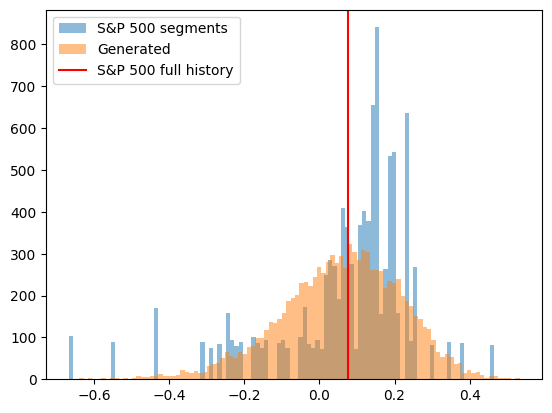

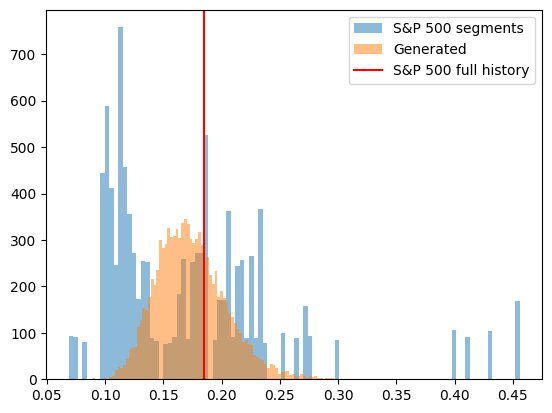

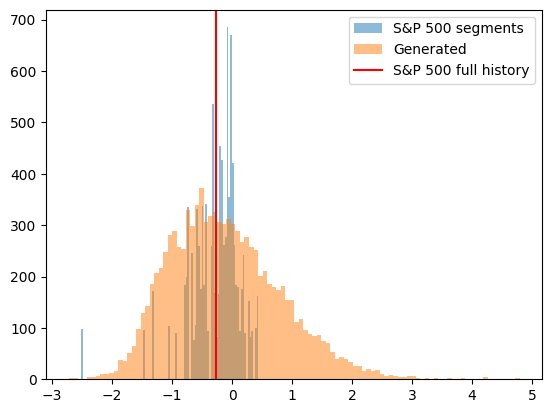

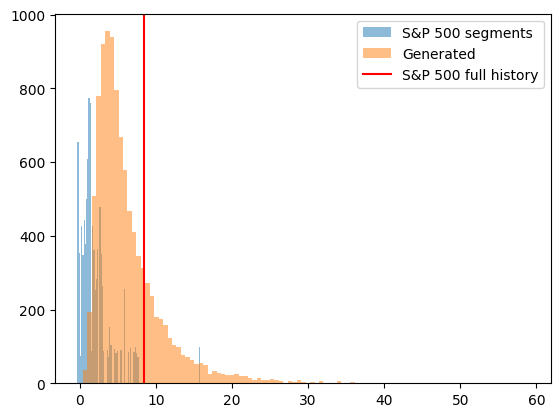

In [20]:
print_statistics(spx_log_returns, ref_mean=mean, ref_std=std, ref_skew=skewness, ref_kurtosis=kurt,
                 log_returns2=log_returns.numpy(), n_bins=100, factor=252)

In [21]:
def get_stats(log_returns, factor=1.):
    means = log_returns.mean(axis=1)*factor
    stds = log_returns.std(axis=1)*factor**0.5
    skews = skew(log_returns, axis=1)
    kurtosises = kurtosis(log_returns, axis=1)
    return [f'{means.mean():.3f} / {means.std():.3f}', f'{stds.mean():.3f} / {stds.std():.3f}', f'{skews.mean():.3f} / {skews.std():.3f}', f'{kurtosises.mean():.3f} / {kurtosises.std():.3f}']

In [22]:
stats_df = pd.DataFrame(columns=['Return Type', 'Ann. Return', 'Ann Volatility', 'Skew', 'Kurtosis'])
stats_df.loc[0] = ['S&P 500 full history', f'{spx_full_log_returns.mean()*252:.3f} / -', f'{spx_full_log_returns.std()*252**0.5:.3f} / -', f'{skew(spx_full_log_returns):.3f} / -', f'{kurtosis(spx_full_log_returns):.3f} / -']
stats_df.loc[1] = ['S&P 500 segments'] + get_stats(spx_log_returns, factor=252)
stats_df.loc[2] = ['Generated'] + get_stats(log_returns, factor=252)
stats_df

,Return Type,Ann. Return,Ann Volatility,Skew,Kurtosis
0,S&P 500 full history,0.077 / -,0.185 / -,-0.271 / -,8.495 / -
1,S&P 500 segments,0.069 / 0.182,0.172 / 0.077,-0.279 / 0.424,2.140 / 2.326
2,Generated,0.058 / 0.161,0.174 / 0.030,-0.113 / 0.930,6.375 / 4.730


In [23]:
def rolling_window(x, k, sparse=True):
    """compute rolling windows from timeseries

    Args:
        x ([2d array]): x contains the time series in the shape (timestep, sample).
        k ([int]): window length.
        sparse (bool): Cut off the final windows containing NA. Defaults to True.

    Returns:
        [3d array]: array of rolling windows in the shape (window, timestep, sample).
    """
    out = np.full([k, *x.shape], np.nan)
    N = len(x)
    for i in range(k):
        out[i, :N-i] = x[i:]

    if not sparse:
        return out

    return out[:, :-(k-1)]

def acf(x, k, le=False):

    arr = rolling_window(x, k, sparse=False)
    a = (arr[0] - np.nanmean(arr[0], axis=0))
    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

def mad(x, axis=None):
    return np.mean(np.abs(x - np.mean(x, axis=axis)), axis=axis)

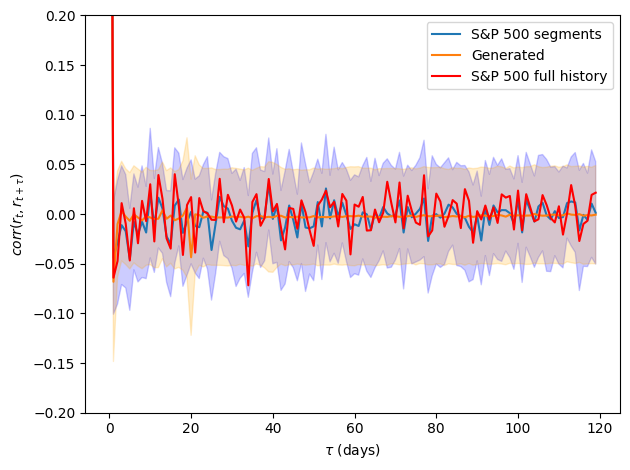

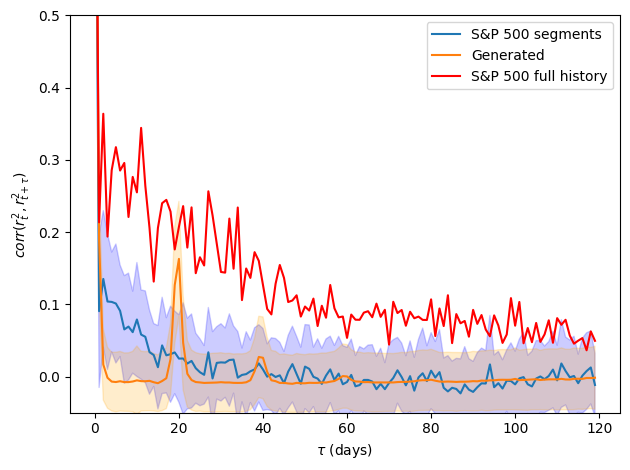

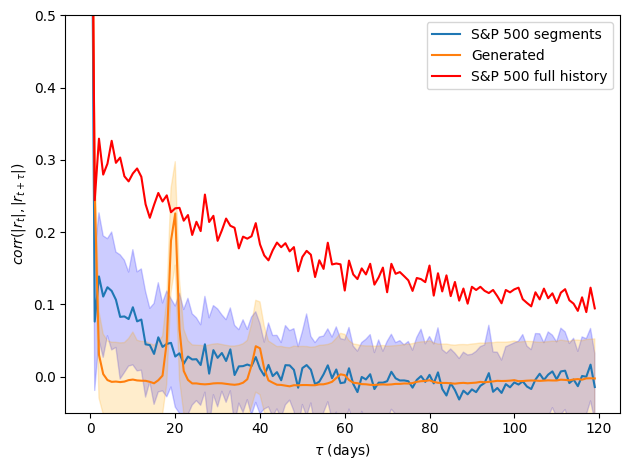

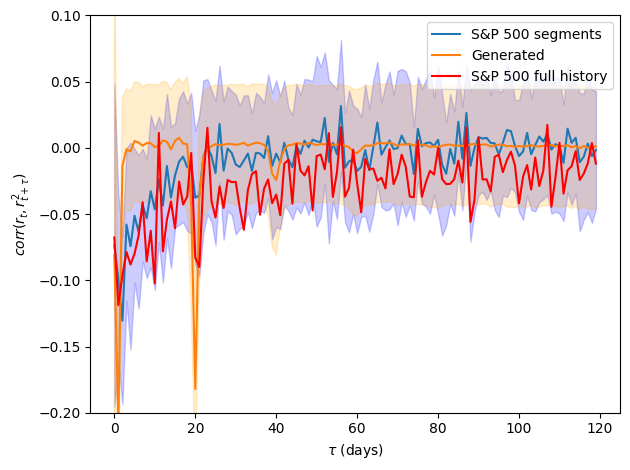

In [24]:

n_days = 120
fig = plt.figure()
ax = plt.subplot()
acf_values = np.array([acf(lr, n_days) for lr in spx_log_returns])
ax.plot(acf_values.mean(axis=0), label='S&P 500 segments')
acf_mad = mad(acf_values, axis=0)
ax.fill_between(np.arange(n_days), acf_values.mean(axis=0) + acf_mad, acf_values.mean(axis=0) - acf_mad, alpha=0.2, color='blue')

acf_values = np.array([acf(lr, n_days) for lr in log_returns])
ax.plot(acf_values.mean(axis=0), label='Generated')
# ax.fill_between(np.arange(n_days), acf_values.min(axis=0), acf_values.max(axis=0), alpha=0.2, color='orange')
acf_mad = mad(acf_values, axis=0)
ax.fill_between(np.arange(n_days), acf_values.mean(axis=0) + acf_mad, acf_values.mean(axis=0) - acf_mad, alpha=0.2, color='orange')

acf_values = acf(spx_full_log_returns, n_days)
ax.plot(acf_values, label='S&P 500 full history', color='red')

ax.set_ylim(-0.2, 0.2)
ax.set_ylabel('$corr(r_t, r_{t+\\tau})$')
plt.setp(ax, xlabel='$\\tau$ (days)')
plt.legend()
plt.tight_layout()

fig = plt.figure()
ax = plt.subplot()
acf_values = np.array([acf(lr**2, n_days) for lr in spx_log_returns])
ax.plot(acf_values.mean(axis=0), label='S&P 500 segments')
acf_mad = mad(acf_values, axis=0)
ax.fill_between(np.arange(n_days), acf_values.mean(axis=0) + acf_mad, acf_values.mean(axis=0) - acf_mad, alpha=0.2, color='blue')

ax.set_ylim(-0.05, 0.5)
ax.set_ylabel('$corr(r_t^2, r_{t+\\tau}^2)$')
acf_values = np.array([acf(lr**2, n_days) for lr in log_returns])
ax.plot(acf_values.mean(axis=0), label='Generated')
# ax.fill_between(np.arange(n_days), acf_values.min(axis=0), acf_values.max(axis=0), alpha=0.2, color='orange')
acf_mad = mad(acf_values, axis=0)
ax.fill_between(np.arange(n_days), acf_values.mean(axis=0) + acf_mad, acf_values.mean(axis=0) - acf_mad, alpha=0.2, color='orange')

acf_values = acf(spx_full_log_returns**2, n_days)
ax.plot(acf_values, label='S&P 500 full history', color='red')

plt.setp(ax, xlabel='$\\tau$ (days)')
plt.legend()
plt.tight_layout()

fig = plt.figure()
ax = plt.subplot()
acf_values = np.array([acf(np.abs(lr), n_days) for lr in spx_log_returns])
ax.plot(acf_values.mean(axis=0), label='S&P 500 segments')
acf_mad = mad(acf_values, axis=0)
ax.fill_between(np.arange(n_days), acf_values.mean(axis=0) + acf_mad, acf_values.mean(axis=0) - acf_mad, alpha=0.2, color='blue')

acf_values = np.array([acf(np.abs(lr), n_days) for lr in log_returns])
ax.plot(acf_values.mean(axis=0), label='Generated')
# ax.fill_between(np.arange(n_days), acf_values.min(axis=0), acf_values.max(axis=0), alpha=0.2, color='orange')
acf_mad = mad(acf_values, axis=0)
ax.fill_between(np.arange(n_days), acf_values.mean(axis=0) + acf_mad, acf_values.mean(axis=0) - acf_mad, alpha=0.2, color='orange')

acf_values = acf(np.abs(spx_full_log_returns), n_days)
ax.plot(acf_values, label='S&P 500 full history', color='red')

ax.set_ylim(-0.05, 0.5)
ax.set_ylabel('$corr(|r_t|, |r_{t+\\tau}|)$')
plt.setp(ax, xlabel='$\\tau$ (days)')
plt.legend()
plt.tight_layout()

fig = plt.figure()
ax = plt.subplot()
acf_values = np.array([acf(lr, n_days, le=True) for lr in spx_log_returns])
ax.plot(acf_values.mean(axis=0), label='S&P 500 segments')
acf_mad = mad(acf_values, axis=0)
ax.fill_between(np.arange(n_days), acf_values.mean(axis=0) + acf_mad, acf_values.mean(axis=0) - acf_mad, alpha=0.2, color='blue')

acf_values = np.array([acf(lr, n_days, le=True) for lr in log_returns])
ax.plot(acf_values.mean(axis=0), label='Generated')
# ax.fill_between(np.arange(n_days), acf_values.min(axis=0), acf_values.max(axis=0), alpha=0.2, color='orange')
acf_mad = mad(acf_values, axis=0)
ax.fill_between(np.arange(n_days), acf_values.mean(axis=0) + acf_mad, acf_values.mean(axis=0) - acf_mad, alpha=0.2, color='orange')

acf_values = acf(spx_full_log_returns, n_days, le=True)
ax.plot(acf_values, label='S&P 500 full history', color='red')

ax.set_ylim(-0.2, 0.1)
ax.set_ylabel('$corr(r_t, r_{t+\\tau}^2)$')
plt.setp(ax, xlabel='$\\tau$ (days)')
plt.legend()
plt.tight_layout()

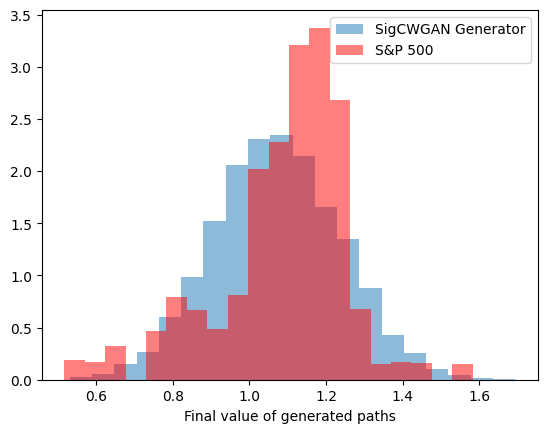

In [25]:
bins = 20
plt.hist(paths[:,-1], bins=bins, density=True, alpha=0.5, label='SigCWGAN Generator');
# filter_idx = paths2[:,-1] < 2.5
# plt.hist(paths2[filter_idx,-1], bins=bins, density=True, alpha=0.5, label='COT-GAN Generator');
# print(paths2.shape[0] - filter_idx.sum())
# print(paths2[~filter_idx,-1])
spx_paths = np.exp(spx_log_returns.cumsum(axis=1)[:,-1])
plt.hist(spx_paths, bins=bins, density=True, alpha=0.5, label='S&P 500', color='red');
plt.xlabel('Final value of generated paths')
plt.legend();

In [26]:
rng_idx = rng.integers(0, x_real_transformed.shape[0]-(args.p+args.q), size=long_dataset_size)
x_fake = []
for i in range(len(rng_idx) // batch_size):
    idx = rng_idx[i*batch_size:(i+1)*batch_size]
    x_past = x_real[idx,:args.p,:].to(base_config.device)
    # print(f'i: {i}, x_past.shape: {x_past.shape}')
    with torch.no_grad():
        x_future = generator.sample(long_length, x_past).detach()
    x_fake.append(x_future)
x_fake = torch.cat(x_fake, dim=0)
x_fake.shape

torch.Size([10000, 7216, 1])

In [27]:
paths = x_fake[:,:,0].clone()
paths = pipeline.inverse_transform(paths)
paths = paths.cumsum(axis=1)
paths = paths.exp()
paths = torch.cat([torch.ones_like(paths[:,:1]), paths], dim=1).cpu()
log_returns = torch.diff(torch.log(paths), dim=1)
torch.save(paths, f'./data/long_paths_p{p}_q{q}.pt')
paths.shape, log_returns.shape

(torch.Size([10000, 7217]), torch.Size([10000, 7216]))

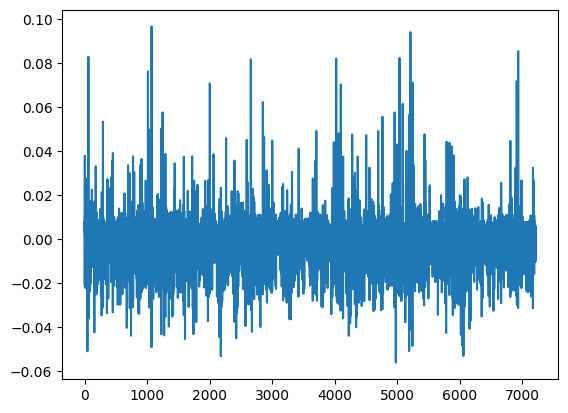

In [28]:
plt.plot(log_returns[5]);

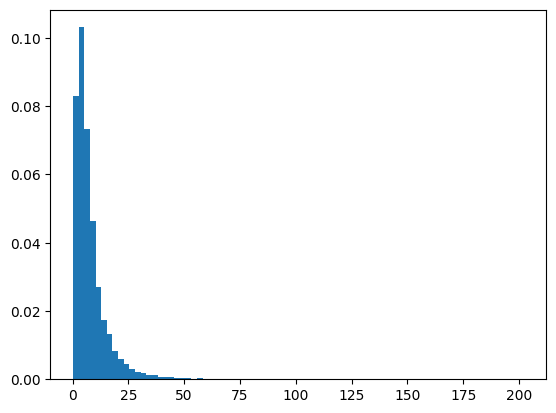

In [29]:
plt.hist(paths[:,-1], density=True, bins=80);

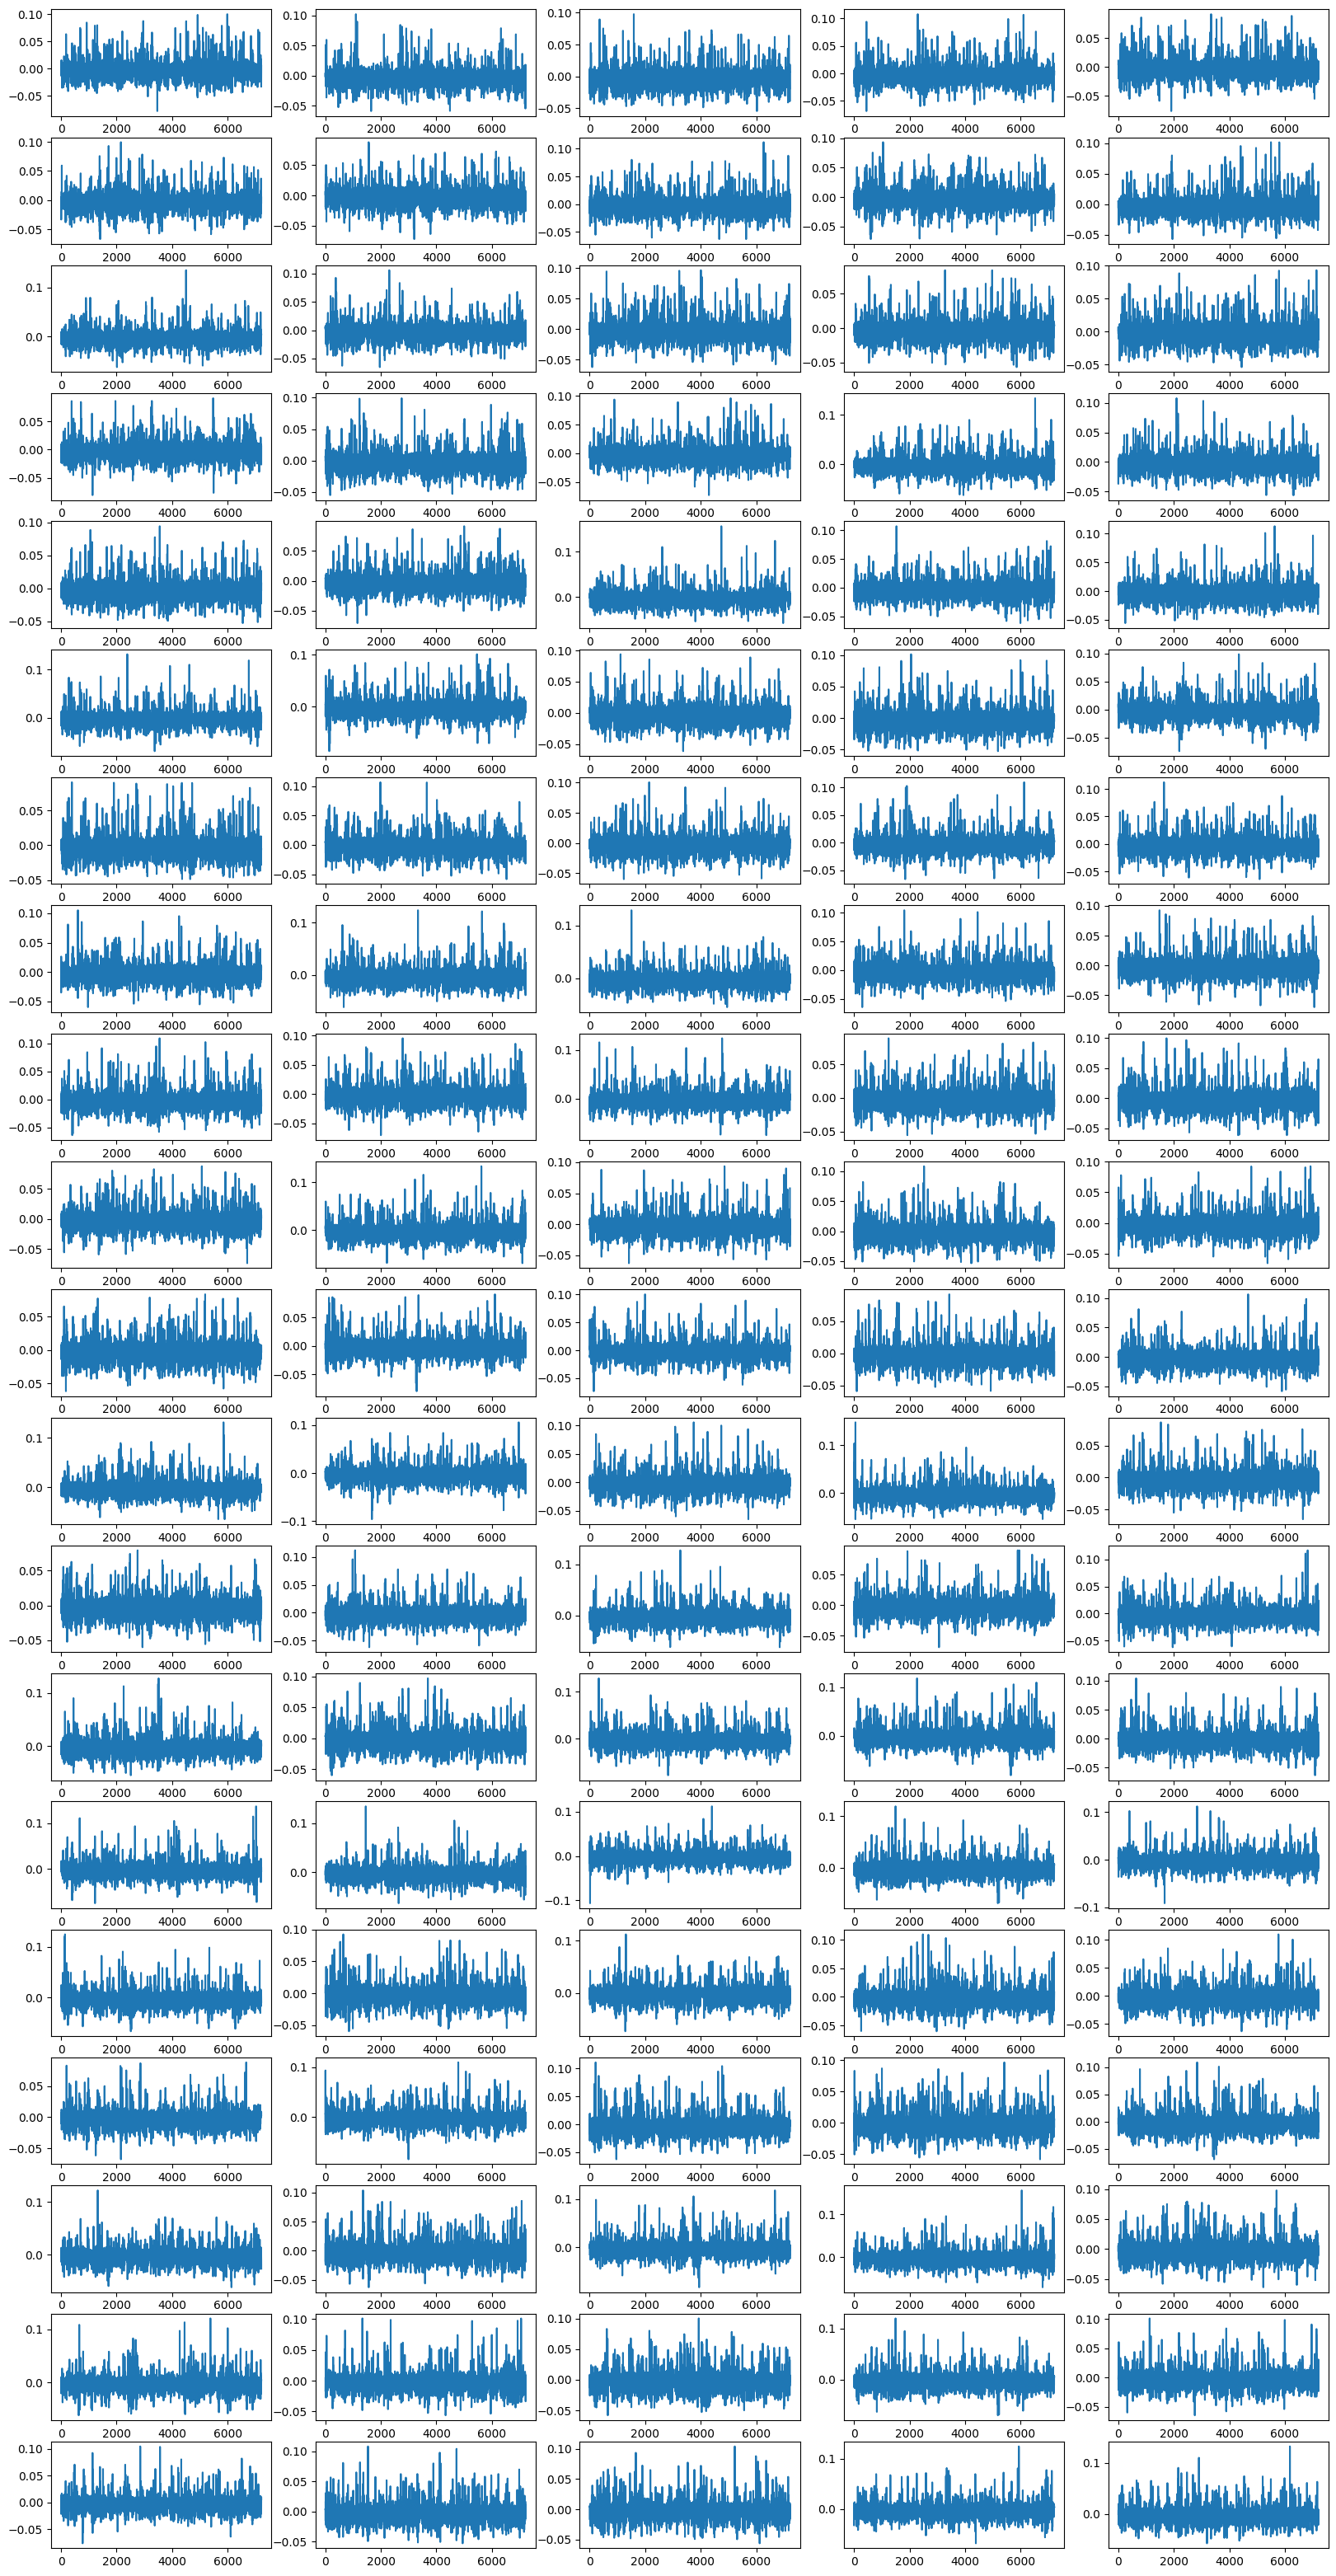

In [30]:
size = 100
row = 5
indices = np.random.randint(0, log_returns.shape[0], size=size)
fig, ax = plt.subplots(size // row, row, figsize=(row*4, size//row*2))
for i in range(size):
    ax[i//row, i%row].plot(log_returns[indices[i]], label='CSigWGAN Generator');